In [2]:
import openmc
import numpy as np

### Constants

In [3]:
BISO_KERNEL_RADIUS   = 0.04 # cm  # r = 400 μm = 0.0400 cm // "800 μm kernel"
BISO_RADIUS          = 0.05 # cm  # r = 500 μm = 0.0500 cm // "100 μm thickness"
BISO_VOLUME          = (4 / 3) * np.pi * (BISO_RADIUS)**3            # volume of single BISO particle
KERNEL_VOLUME        = (4 / 3) * np.pi * (BISO_KERNEL_RADIUS)**3     # volume of UO2/ThO2 kernel in single BISO particle
BISO_KERNEL_VOL_FRAC = KERNEL_VOLUME / BISO_VOLUME  # vol frac kernel in single BISO
BISO_COAT_VOL_FRAC   = 1.0 - BISO_KERNEL_VOL_FRAC

### Materials

In [5]:
""" BISO particle """
# UO2 fuel kernel
uo2 = openmc.Material(name='UO2', temperature=900)
uo2.add_element('U', 1.0, enrichment=0.71)  
uo2.add_element('O', 2.0)
uo2.set_density('g/cm3', 10.5)

# SiC coating
sic = openmc.Material(name='SiC', temperature=900)
sic.add_element('Si', 1.0)
sic.add_element('C', 1.0)
sic.set_density('g/cm3', 3.2)

# BISO
biso = openmc.Material.mix_materials([uo2, sic], [BISO_KERNEL_VOL_FRAC, BISO_COAT_VOL_FRAC], 'vo')


""" Breeding material """
# Lead-lithium (Pb83at%-Li17at%)
pbli = openmc.Material(name='PbLi', temperature=900)
pbli.add_element('Pb', 0.83)
pbli.add_element('Li', 0.1, enrichment_target='Li6', enrichment_type='wo', enrichment=90.0)
pbli.set_density('g/cm3', 9.5) 

# FLiBe (LiF-BeF2)
flibe = openmc.Material(name='FLiBe', temperature=900)
flibe.add_elements_from_formula('F4Li2Be', 'ao', enrichment_target='Li6', enrichment_type='wo', enrichment=7.5)
flibe.set_density('g/cm3', 1.94) 


""" Homogeneous breeding mixtures """
flibe_mix_01  = openmc.Material.mix_materials([flibe, biso], [0.99, 0.01], 'vo')
flibe_mix_50  = openmc.Material.mix_materials([flibe, biso], [0.50, 0.50], 'vo')
pbli_mix_01  = openmc.Material.mix_materials([pbli, biso], [0.99, 0.01], 'vo')
pbli_mix_50  = openmc.Material.mix_materials([pbli, biso], [0.50, 0.50], 'vo')


""" Materials """
materials = openmc.Materials([uo2, sic, flibe, pbli, biso,
                              flibe_mix_01, flibe_mix_50, pbli_mix_01, pbli_mix_50])
materials.cross_sections = '/mnt/c/OpenMC/data/endfb-viii.0-hdf5/cross_sections.xml'
# materials.export_to_xml()

### Geometry

#### Helper functions

In [13]:
def cube_dims(biso_vol_frac):
    cube_length = ((4/3 * np.pi * BISO_RADIUS**3)/biso_vol_frac)**(1/3)
    cube_half   = cube_length / 2
    return cube_length, cube_half

def periodic_box(cube_half, offsets):

    xs = openmc.XPlane(x0= -cube_half + offsets[0], boundary_type = 'periodic')
    xg = openmc.XPlane(x0=  cube_half + offsets[0], boundary_type = 'periodic')

    ys = openmc.YPlane(y0= -cube_half + offsets[1], boundary_type = 'periodic')
    yg = openmc.YPlane(y0=  cube_half + offsets[1], boundary_type = 'periodic')

    zs = openmc.ZPlane(z0= -cube_half + offsets[2], boundary_type = 'periodic')
    zg = openmc.ZPlane(z0=  cube_half + offsets[2], boundary_type = 'periodic')

    xs.periodic_surface, ys.periodic_surface, zs.periodic_surface = xg, yg, zg

    region = +xs & -xg & +ys & -yg & +zs & -zg
    return region

def heterogeneous(biso_vol_frac, breeder, offsets, label):
    uo2_outer = openmc.Sphere(x0=offsets[0], y0=offsets[1], z0=offsets[2], r=BISO_KERNEL_RADIUS)
    sic_outer = openmc.Sphere(x0=offsets[0], y0=offsets[1], z0=offsets[2], r=BISO_RADIUS)
    
    # UO2 kernel
    cell_uo2 = openmc.Cell(name=f'UO2 in cell: {label}')
    cell_uo2.fill = uo2
    cell_uo2.region = -uo2_outer
    
    # SiC coating
    cell_sic = openmc.Cell(name=f'SiC in cell: {label}')
    cell_sic.fill = sic
    cell_sic.region = +uo2_outer & -sic_outer
    
    # FLiBe
    cube_length, cube_half = cube_dims(biso_vol_frac)
    cell_breeder = openmc.Cell(name=f'Breeder in cell: {label}')
    cell_breeder.fill = breeder
    cell_breeder.region = +sic_outer & periodic_box(cube_length, offsets)
    return [cell_uo2, cell_sic, cell_breeder]

#### Generate cells
Boxes arranged in array where $i$-th entry is breeder material and $j$-th entry indicates BISO volume fraction and mixture.

In [60]:
""" Cells """
# BISO particle
uo2_outer = openmc.Sphere(r=BISO_KERNEL_RADIUS) # UO2 kernel sphere (radius = 0.04 cm)
sic_outer = openmc.Sphere(r=BISO_RADIUS)        # # SiC coating outer surface (radius = 0.04 + 0.01 = 0.05 cm)

# Cubes
cube_length_01, cube_half_01 = cube_dims(0.01)
cube_length_50, cube_half_50 = cube_dims(0.50)
# print(f"{cube_length_01:.6f}, {cube_half_01:.6f}")
# print(f"{cube_length_50:.6f}, {cube_half_50:.6f}")

x_coords = [0, 0.5, 1.0, 1.5]
y_coords = [0, -0.5]
coords = np.array([[(x, y, 0) for x in x_coords] for y in y_coords]) # 2 x 4 matrix of coordinates
# print(coords)

cells = []
# FLiBe -  1 vol% BISO - homogeneous
cell_flibe_01_ho        = openmc.Cell(name='FLiBe -  1 vol% BISO - homogeneous')
cell_flibe_01_ho.fill   = flibe_mix_01
cell_flibe_01_ho.region = periodic_box(cube_half_01, coords[0,0])
cells.append(cell_flibe_01_ho)

# FLiBe -  1 vol% BISO - heterogeneous
cells += heterogeneous(0.01, flibe, coords[0,1], "FLiBe -  1 vol% BISO - heterogeneous") 

# FLiBe - 50 vol% BISO - homogeneous
cell_flibe_50_ho        = openmc.Cell(name='FLiBe - 50 vol% BISO - homogeneous')
cell_flibe_50_ho.fill   = flibe_mix_50
cell_flibe_50_ho.region = periodic_box(cube_half_50, coords[0,2])
cells.append(cell_flibe_50_ho)

# FLiBe - 50 vol% BISO - heterogeneous
cells += heterogeneous(0.50, flibe, coords[0,3], "FLiBe - 50 vol% BISO - heterogeneous") 

# LL -  1 vol% BISO - homogeneous
cell_ll_01_ho        = openmc.Cell(name='LL -  1 vol% BISO - homogeneous')
cell_ll_01_ho.fill   = pbli_mix_01
cell_ll_01_ho.region = periodic_box(cube_half_01, coords[1,0])
cells.append(cell_ll_01_ho)

# LL -  1 vol% BISO - heterogeneous
cells += heterogeneous(0.01, pbli, coords[1,1], "LL -  1 vol% BISO - heterogeneous") 

# LL - 50 vol% BISO - homogeneous
cell_ll_50_ho        = openmc.Cell(name='LL - 50 vol% BISO - homogeneous')
cell_ll_50_ho.fill   = pbli_mix_50
cell_ll_50_ho.region = periodic_box(cube_half_50, coords[1,2])
cells.append(cell_ll_50_ho)

# LL - 50 vol% BISO - heterogeneous
cells += heterogeneous(0.50, pbli, coords[1,3], "LL - 50 vol% BISO - heterogeneous") 

# Create universe and geometry
root_universe = openmc.Universe(cells=cells)
geometry = openmc.Geometry(root_universe)
# geometry.export_to_xml()

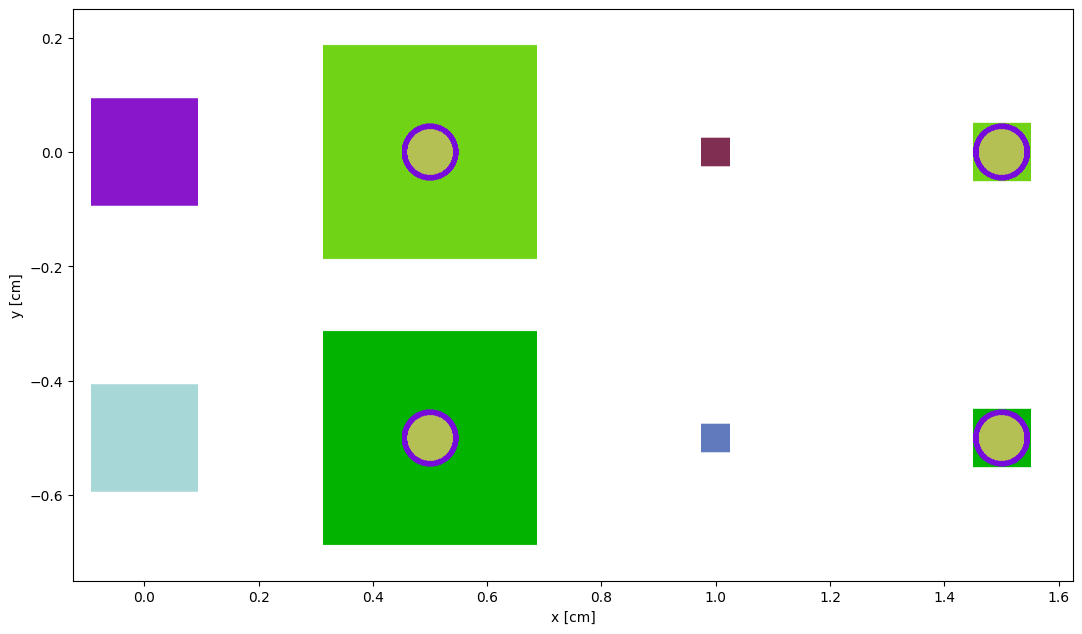

In [64]:
img = geometry.plot(origin=(0.75, -0.25, 0),
                    basis='xy',                           # slice plane
                    width=(1.75, 1.0),     # cm window
                    pixels=(1000, 1000),
                    color_by='material')

In [ ]:
settings = openmc.Settings()

"""Source: 14 MeV"""
source = openmc.IndependentSource()
source.space = openmc.stats.Box([-1*cube_half, -1*cube_half, -1*cube_half], [cube_half, cube_half, cube_half])
source.particle = 'neutron'
source.constraints = {'fissionable': False}
source.energy = openmc.stats.Discrete(energies, weights) # openmc.stats.Discrete([14.0e6], [1.0])  # 14 MeV
# source.angle    = openmc.stats.Monodirectional((1, 0, 0))
source.angle = openmc.stats.Isotropic()


"""Settings"""
settings.run_mode  = "fixed source"
settings.batches   = 1
settings.particles = int(1e8)
settings.source    = [source]
settings.volume_normalized_flux_tallies = True
# settings.write_initial_source = True
# settings.sourcepoint = {'batches':[10],'write':True}

In [ ]:
"""Tallies"""
tallies = openmc.Tallies()

# total rxn rates
t_tot = openmc.Tally(name="total rxn rates")
t_tot.scores = ["absorption", "fission", "(n,gamma)", "(n,Xt)"]
tallies.append(t_tot)

# rxn rates by isotope
t_iso = openmc.Tally(name="rxn rates by isotope")
t_iso.scores = ["absorption", "fission", "(n,gamma)", "(n,Xt)"]
t_iso.nuclides = ['U238', 'U235']
tallies.append(t_iso)

In [ ]:
model = openmc.Model(geometry, materials, settings, tallies)
model.export_to_model_xml("./BISO_LL_homogeneous")
model.run(cwd="./BISO_LL_homogeneous") 